# Import modules and load the variables

In [ ]:
import requests
from datetime import datetime, timedelta
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os

# Load the dot_env env
load_dotenv()

# Assign Env variables
api_key = os.getenv("API_KEY") 
api_base_url = os.getenv("API_BASE_URL") 
db_url = os.getenv("DATABASE_URL")  # Use the DATABASE_URL from the environment variables


# Define the base URL and headers
base_url_locations = "https://api.openaq.org/v2/locations"
base_url_measurements = "https://api.openaq.org/v2/measurements"
headers = {
    "X-API-Key": api_key  # Replace with your OpenAQ API key
}

# Step 1: Find the Location ID for Salt Lake City
params_locations = {
    "city": "Salt Lake City",
    "limit": 1
}

response_locations = requests.get(base_url_locations, headers=headers, params=params_locations)
if response_locations.status_code == 200:
    data_locations = response_locations.json()
    location_id = data_locations['results'][0]['id']
    print(f"Location ID for Salt Lake City: {location_id}")
else:
    print(f"Error: {response_locations.status_code}")
    exit()

# Step 2: Query Historical Data for the Past 30 Days
end_date = datetime.now()
start_date = end_date - timedelta(days=365)
params_measurements = {
    "location_id": location_id,
    "date_from": start_date.isoformat(),
    "date_to": end_date.isoformat(),
    "limit": 1000
}

response_measurements = requests.get(base_url_measurements, headers=headers, params=params_measurements)
if response_measurements.status_code == 200:
    data_measurements = response_measurements.json()
    print(json.dumps(data_measurements, indent=4))
else:
    print(f"Error: {response_measurements.status_code}")

Location ID for Salt Lake City: 288
{
    "meta": {
        "name": "openaq-api",
        "license": "",
        "website": "/",
        "page": 1,
        "limit": 1000,
        "found": ">1000"
    },
    "results": [
        {
            "locationId": 288,
            "location": "Hawthorne",
            "parameter": "co",
            "value": 0.1,
            "date": {
                "utc": "2025-01-23T21:00:00+00:00",
                "local": "2025-01-23T14:00:00-07:00"
            },
            "unit": "ppm",
            "coordinates": {
                "latitude": 40.733501,
                "longitude": -111.87169600000001
            },
            "country": "US",
            "city": null,
            "isMobile": false,
            "isAnalysis": null,
            "entity": "Governmental Organization",
            "sensorType": "reference grade"
        },
        {
            "locationId": 288,
            "location": "Hawthorne",
            "parameter": "co",
           

# Clean and flatten the data

In [21]:
# Step 3: Load the Data into a DataFrame
df = pd.json_normalize(data_measurements['results'])

# Step 4: Flatten Any Nested Structures
# Example: Flatten the 'coordinates' column if it exists
if 'coordinates' in df.columns:
    coordinates_df = pd.json_normalize(df['coordinates'])
    coordinates_df.columns = [f"coordinates_{col}" for col in coordinates_df.columns]
    df = df.drop(columns=['coordinates']).join(coordinates_df)

# Print the flattened DataFrame
print("Flattened DataFrame:")
print(df.head())



Flattened DataFrame:
   locationId   location parameter  value unit country  city  isMobile  \
0         288  Hawthorne        co    0.2  ppm      US  None     False   
1         288  Hawthorne        co    0.2  ppm      US  None     False   
2         288  Hawthorne        co    0.3  ppm      US  None     False   
3         288  Hawthorne        co    0.6  ppm      US  None     False   
4         288  Hawthorne        co    0.8  ppm      US  None     False   

  isAnalysis                     entity       sensorType  \
0       None  Governmental Organization  reference grade   
1       None  Governmental Organization  reference grade   
2       None  Governmental Organization  reference grade   
3       None  Governmental Organization  reference grade   
4       None  Governmental Organization  reference grade   

                    date.utc                 date.local  coordinates.latitude  \
0  2025-01-23T20:00:00+00:00  2025-01-23T13:00:00-07:00             40.733501   
1  2025-01-

# Visualize

Flattened DataFrame:
   locationId   location parameter  value unit country  city  isMobile  \
0         288  Hawthorne        co    0.2  ppm      US  None     False   
1         288  Hawthorne        co    0.2  ppm      US  None     False   
2         288  Hawthorne        co    0.3  ppm      US  None     False   
3         288  Hawthorne        co    0.6  ppm      US  None     False   
4         288  Hawthorne        co    0.8  ppm      US  None     False   

  isAnalysis                     entity       sensorType  \
0       None  Governmental Organization  reference grade   
1       None  Governmental Organization  reference grade   
2       None  Governmental Organization  reference grade   
3       None  Governmental Organization  reference grade   
4       None  Governmental Organization  reference grade   

                   date.utc                 date.local  coordinates.latitude  \
0 2025-01-23 20:00:00+00:00  2025-01-23T13:00:00-07:00             40.733501   
1 2025-01-23 

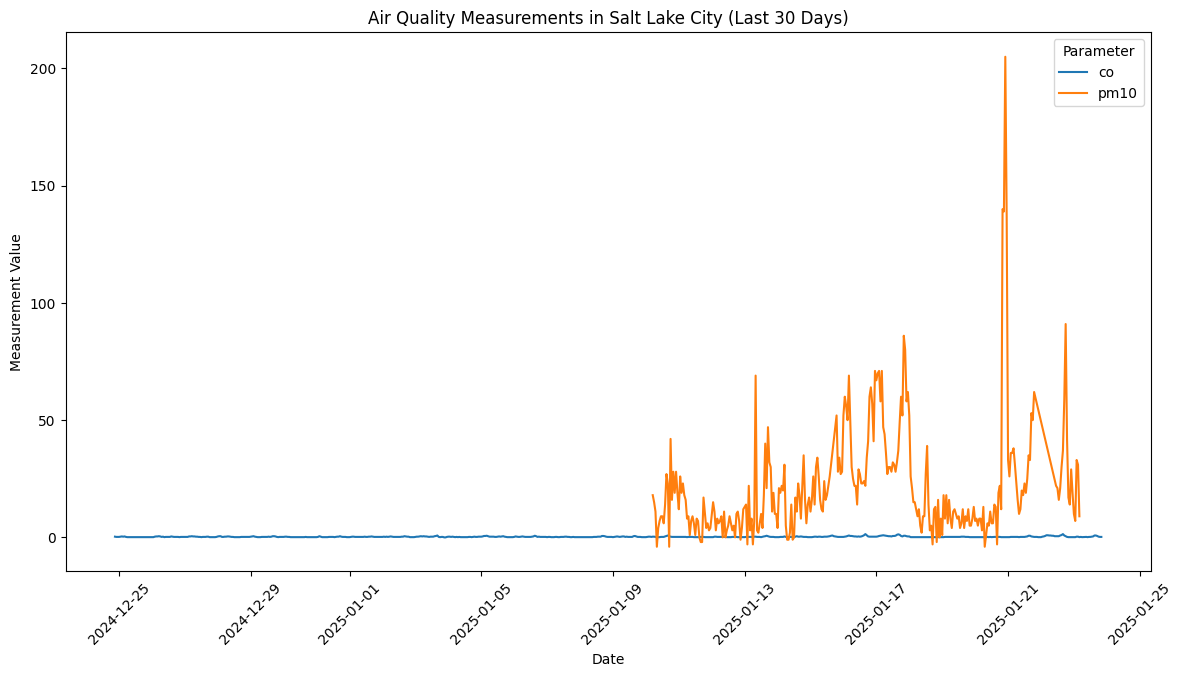

In [25]:
# Convert the 'date.utc' column to datetime
df['date.utc'] = pd.to_datetime(df['date.utc'])

# Print the flattened DataFrame
print("Flattened DataFrame:")
print(df.head())

# Step 5: Visualize the Data
# Example: Plot PM2.5 levels over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='date.utc', y='value', hue='parameter')
plt.title('Air Quality Measurements in Salt Lake City (Last 30 Days)')
plt.xlabel('Date')
plt.ylabel('Measurement Value')
plt.legend(title='Parameter')
plt.xticks(rotation=45)
plt.show()